In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

##### 1. แยกได้ยังไงว่าตรงไหนเป็นสีขาวจากเมฆ และสีขาวจากแสงอาทิตย์

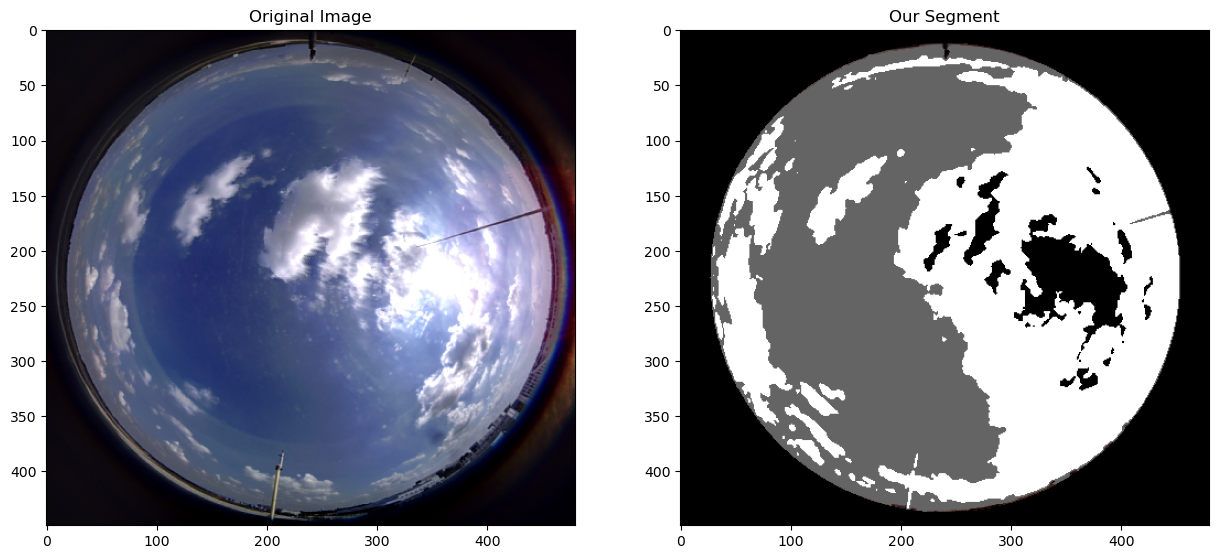

In [37]:
## crop 
image = cv2.imread('../WSISEG-Database/whole sky images/ASC100-1006_001')
r1 = image.shape[1]
r2 = image.shape[0]
mask = np.zeros((r2, r1), dtype=np.uint8)

cv2.circle(mask, (int(r1/2), int(r2/2)), 213, (255, 255, 255), -1, 8, 0)

masked = cv2.bitwise_and(image, image, mask=mask)
# plt.imshow(masked)

## Find contour of the sun
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
img_eql = cv2.equalizeHist(gray)
blur = cv2.GaussianBlur(img_eql,(5,5),0)

# Apply a color threshold to segment clear sky 
_, thresh1 = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
contours_sky, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(masked, contours_sky, -1, (100, 100, 100), thickness=cv2.FILLED)

# Apply a color threshold to segment cloud
_, thresh2 = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
contours_cloud, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(masked, contours_cloud, -1, (255, 255, 255), thickness=cv2.FILLED)

# Apply a color threshold to create a binary image # T = 240 can detect sun light
_, thresh3 = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY)
# Use contour detection to identify the outline of the circle
contours_sun, _ = cv2.findContours(thresh3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(masked, contours_sun, -1, (0, 0, 0), thickness=cv2.FILLED)

f, (axz1, axz2) = plt.subplots(1,2, figsize=(15, 15))
axz1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axz1.title.set_text('Original Image')
axz2.imshow(masked)
axz2.title.set_text('Our Segment')
# plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))


In [24]:
annotate = cv2.imread('../WSISEG-Database/annotation/ASC100-1006_001')

#### 3. จะรู้ได้อย่างไรว่าที่เราทำ segmentation มามันมีประสิทธิภาพมากน้อยแค่ไหน

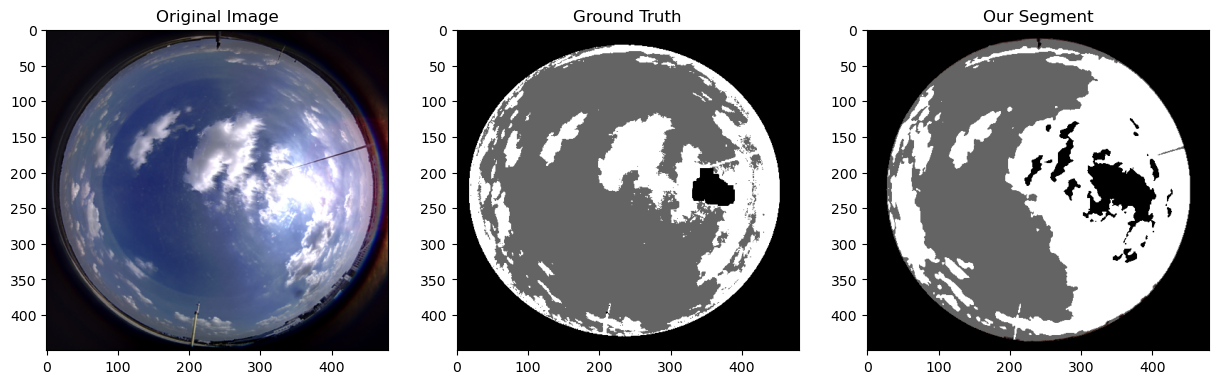

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.title.set_text('Original Image')
ax2.imshow(annotate)
ax2.title.set_text('Ground Truth')
ax3.imshow(masked)
ax3.title.set_text('Our Segment')

In [27]:
from keras import backend as K
import tensorflow as tf
def sparse_Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    pred_pixels = K.argmax(y_pred, axis=-1)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(y_true[:,:,0], i)
        pred_labels = K.equal(pred_pixels, i)
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0 
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)

In [28]:
sparse_Mean_IOU(annotate, masked)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3615972222222223>

In [29]:
## Cloud cover estimation of annotation
clear = np.sum(annotate==100)
cloud = np.sum(annotate==255)
undefine = np.sum(annotate==0)

total = cloud+clear
cloud_cover = (cloud/total)*100
print(cloud_cover)

30.90708654564443


In [30]:
## Cloud cover estimation of our segment
clear_masked = np.sum(masked==100)
cloud_masked = np.sum(masked==255)
undefine_masked = np.sum(masked==0)

total_masked = cloud_masked + clear_masked
cloud_cover_masked = (cloud_masked/total_masked)*100
print(cloud_cover_masked)

50.70705962441432


In [36]:
import math
actual = [cloud_cover]
pred = [cloud_cover_masked]

MSE = np.square(np.subtract(actual,pred)).mean() 
RMSE = math.sqrt(MSE)

print("Mean Square Error:", MSE)
print("Root Mean Square Error:", RMSE)

Mean Square Error: 392.0389339200125
Root Mean Square Error: 19.79997307876989


Ref metric: https://github.com/Golbstein/KerasExtras/blob/master/keras_functions.py

In [148]:
def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)